In [1]:
%load_ext autoreload
%autoreload 2

# Readme
Change dataset, crop_id, obj_id only

# 1. Crop images

In [2]:
# load sam
from src.model.sam import CustomSamAutomaticMaskGenerator, load_sam
from segment_anything.modeling.sam import Sam
model_type = "vit_h"
checkpoint_dir =  "datasets/bop23_challenge/pretrained/segment-anything"
sam_model = load_sam(model_type, checkpoint_dir)
custom_sam_model = CustomSamAutomaticMaskGenerator(sam=sam_model) #, crop_overlap_ratio = 750 / 1500) # , box_nms_thresh = 0.6 )

In [3]:
def move_to_device(segmentor_model, device="cuda"):
    # if there is predictor in the model, move it to device
    if hasattr(segmentor_model, "predictor"):
        segmentor_model.predictor.model = (
            segmentor_model.predictor.model.to(device)
        )
    else:
        segmentor_model.model.setup_model(device=device, verbose=True)
move_to_device(custom_sam_model)

In [4]:
from PIL import Image
import torch
import numpy as np
from src.model.utils import Detections

dataset = "icbin"
rgb_path = "cnos_analysis/crop_proposals/000001.png" # f"datasets/bop23_challenge/datasets/{dataset}/test/000048/rgb/000001.png"
rgb = Image.open(rgb_path).convert("RGB")
sam_detections = custom_sam_model.generate_masks(np.array(rgb))

In [5]:
def extract_object_by_mask(image, mask, width: int = 512):
    mask = Image.fromarray(mask)
    masked_image = Image.composite(
        image, Image.new("RGB", image.size, (0, 0, 0)), mask)
    cropped_image = masked_image.crop(masked_image.getbbox())
    # new_height = width * cropped_image.height // cropped_image.width
    return cropped_image

masked_images = []
for mask in sam_detections["masks"].cpu():
    binary_mask = np.array(mask) * 255
    binary_mask = binary_mask.astype(np.uint8)
    masked_image = extract_object_by_mask(rgb, binary_mask)
    masked_images.append(masked_image)

In [6]:
# # Visualize proposals
# import matplotlib.pyplot as plt
# from math import ceil
# def plot_images(images, rows, cols):
#     fig, axes = plt.subplots(rows, cols, figsize=(20, 30))
#     for i, ax in enumerate(axes.flat):
#         if i >= len(images):
#             break
#         ax.imshow(images[i])
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()

# # Define the number of rows and columns in the grid
# rows = ceil(len(masked_images) / 6)
# cols = 6
# # Plot the masked_images array in a grid
# plot_images(masked_images, rows, cols) 

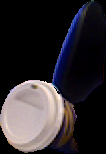

In [6]:
import os

# Choose crop 4 it is in object id 12
crop_idx = 131 # 125, 102 for background; 131 for foreground
obj_id = 1
crop1 = {
    "crop" : masked_images[crop_idx], # it is saved as Image so crop1["crop"] to visualize it
    "masks" : sam_detections["masks"][crop_idx],
    "boxes" : sam_detections["boxes"][crop_idx]
}

# Save image
if not os.path.exists(f"foundpose_analysis/{dataset}"):
    os.makedirs(f"foundpose_analysis/{dataset}")
crop1["crop"].save(f"foundpose_analysis/{dataset}/crop1.png")
crop1["crop"]

In [7]:
obj_id = 1

# 2. Templates

## 2.1 Create templates of object

In [8]:
# load config file
import hydra
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, compose

# Initialize Hydra and compose the configuration
initialize(config_path="configs")
cfg = compose(config_name="run_inference")
OmegaConf.set_struct(cfg, False)

/tmp/ipykernel_965946/531409554.py:7: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="configs")


In [9]:
import os
import glob

default_ref_dataloader_config = cfg.data.reference_dataloader
ref_dataloader_config = default_ref_dataloader_config.copy()
ref_dataloader_config._target_ = "src.dataloader.bop_pbr.BOPTemplatePBR"
ref_dataloader_config.root_dir = f"datasets/bop23_challenge/datasets/{dataset}"
ref_dataloader_config.template_dir = " "

level_template = 1 # Level 0 :42 templates, level 1, 162 templates
ref_dataloader_config.level_templates = level_template 
ref_dataloader_config.split = "train_pbr" # train_pbr

ply_files = glob.glob(f"datasets/bop23_challenge/datasets/{dataset}/models/models/*.ply")
obj_ids = sorted([int(os.path.basename(obj_id)[8:10]) for obj_id in ply_files])
ref_dataloader_config.obj_ids = obj_ids

out_folder = f"foundpose_analysis/{dataset}/templates"
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
ref_dataloader_config.out_dir = out_folder
ref_dataloader_config.templates_output_folder = f"{out_folder}/level_template_{level_template}"

In [11]:
import os
os.environ['HYDRA_FULL_ERROR'] = '1'

In [12]:
# # Error : must delete all metadata.csv 
# # If using test it can happen that the object id doesnt appear in the test folder- so can get empty list - just use try except la ok
# from hydra.utils import instantiate
# ref_dataset = instantiate(ref_dataloader_config) # src.dataloader.bop.BOPTemplatePBR
# ref_dataset.load_processed_metaData(reset_metaData=True)

In [13]:
# from torchvision.utils import save_image
# import pandas as pd

# templates = pd.read_csv(f"{out_folder}/{ref_dataloader_config.split}_processed_metaData.csv")

# # Save templates as images
# for ob_id in range(len(obj_ids)): 
#     obj_id_path = os.path.join(f"{out_folder}/{ref_dataloader_config.split}_images_templates", f'obj_{(ob_id+1):06d}') # The transformed templates - check line 244, 245 in bop_pbr.py
#     original_obj_id_path = os.path.join(f"{out_folder}/{ref_dataloader_config.split}_images_templates", f'obj_{(ob_id+1):06d}_original')
    
#     if not os.path.exists(obj_id_path):
#         os.makedirs(obj_id_path)
#     if not os.path.exists(original_obj_id_path):
#         os.makedirs(original_obj_id_path)

#     try:  
#         for i, img in enumerate(ref_dataset[ob_id]["templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
#             save_image(img, os.path.join(obj_id_path, f'{i:06d}.png'))
#         for i, img in enumerate(ref_dataset[ob_id]["original_templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
#             save_image(img, os.path.join(original_obj_id_path, f'{i:06d}.png'))
#     except Exception as e:
#         print(f"An error occurred: {e}")

## 2.2. Templates features extraction

In [10]:
import glob
import os

obj_id_2 = 2
real_data_type = "test" # test

# Load original templates when before putting through dinov2 we also apply transfomation.
real_template_path_1 = f"{out_folder}/{real_data_type}_images_templates/obj_{obj_id:06d}_original" 
real_template_path_2 = f"{out_folder}/{real_data_type}_images_templates/obj_{obj_id_2:06d}_original" 
real_template_files_1 = sorted(glob.glob(os.path.join(real_template_path_1, "*.png")), key=os.path.getmtime)
real_template_files_2 = sorted(glob.glob(os.path.join(real_template_path_2, "*.png")), key=os.path.getmtime)
real_template_files = real_template_files_1 # + real_template_files_2
real_num_templates = len(real_template_files)
real_num_templates

0

In [11]:
import glob
import os

obj_id_2 = 2
syn_data_type = "train_pbr" # test

# Load original templates when before putting through dinov2 we also apply transformation.
syn_template_path_1 = f"{out_folder}/{syn_data_type}_images_templates/obj_{obj_id:06d}_original" 
syn_template_path_2 = f"{out_folder}/{syn_data_type}_images_templates/obj_{obj_id_2:06d}_original" 
syn_template_files_1 = sorted(glob.glob(os.path.join(syn_template_path_1, "*.png")), key=os.path.getmtime)
syn_template_files_2 = sorted(glob.glob(os.path.join(syn_template_path_2, "*.png")), key=os.path.getmtime)
syn_template_files = syn_template_files_1 # + syn_template_files_2
syn_num_templates = len(syn_template_files)
syn_num_templates

162

In [12]:
import glob
import os

obj_id_2 = 2

# Load original templates when before putting through dinov2 we also apply transformation.
pyrender_template_path_1 = f"datasets/bop23_challenge/datasets/templates_pyrender/icbin/obj_{obj_id:06d}" 
pyrender_template_path_2 = f"datasets/bop23_challenge/datasets/templates_pyrender/icbin/obj_{obj_id_2:06d}" 
pyrender_template_files_1 = sorted(glob.glob(os.path.join(pyrender_template_path_1, "*.png")), key=os.path.getmtime)
pyrender_template_files_2 = sorted(glob.glob(os.path.join(pyrender_template_path_2, "*.png")), key=os.path.getmtime)
pyrender_template_files = pyrender_template_files_1 # + pyrender_template_files_2
pyrender_num_templates = len(pyrender_template_files)
pyrender_num_templates

162

In [13]:
from PIL import Image
import numpy as np


# [50:450, 150:500, :3] only for pyrender template not for BlenderProc templates
real_templates = [np.array(Image.open(template_file).convert("RGB"))[:,:,:3] for template_file in real_template_files] # This image has 4 channels- the last one is not crucial - maybe about opacity
syn_templates = [np.array(Image.open(template_file).convert("RGB"))[:,:,:3]/255.0 for template_file in syn_template_files] # This image has 4 channels- the last one is not crucial - maybe about opacity
pyrender_templates = [np.array(Image.open(template_file).convert("RGB"))[50:450, 150:500, :3]/255.0 for template_file in pyrender_template_files]

In [18]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
# dinov2_vitl14.patch_size = 14
# if torch.cuda.is_available():
#     dinov2_vitl14 = torch.nn.DataParallel(dinov2_vitl14).to(device)  # Use DataParallel for multiple GPUs

In [19]:
# from src.model.custom_cnos import cnos_templates_feature_extraction

# real_ref_features = cnos_templates_feature_extraction(
#     templates = real_templates, num_templates = real_num_templates, dino_model = dinov2_vitl14, device = device
#     )
# syn_ref_features = cnos_templates_feature_extraction(
#     templates = syn_templates, num_templates = syn_num_templates, dino_model = dinov2_vitl14, device = device
#     )
# pyrender_ref_features = cnos_templates_feature_extraction(
#     templates = pyrender_templates, num_templates = pyrender_num_templates, dino_model = dinov2_vitl14, device = device
#     )

# 3. Compare using trained model

In [14]:
from src.model.custom_cnos import check_similarity, check_similarity_2


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model_path = "contrastive_learning/saved_checkpoints/best_model_checkpoint_pyrender_sam.pth"
crop_path = "cnos_analysis/crop_proposals/crop1.png"
crop_rgb = np.transpose(np.array(Image.open(crop_path).convert("RGB"))[:,:,:3]/255.0, (2,0,1)) # (124, 157, 3)

check_similarity_2(best_model_path=best_model_path, crop_rgb=crop_rgb, templates=syn_templates, device=device)
# see the results lb it is quite inconsitent- it means we lack data augmentation and also the dataset needs to be expanded for more cases for postive pairs

Using cache found in /home/cuong.van-dam/.cache/torch/hub/facebookresearch_dinov2_main
/home/cuong.van-dam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/cuong.van-dam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/cuong.van-dam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


Prediction: tensor([0, 1, 0, 1, 1])


1

In [15]:
masked_images[9]

AttributeError: 'Image' object has no attribute 'shape'

In [ ]:
from src.model.custom_cnos import check_similarity, check_similarity_2


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model_path = "contrastive_learning/saved_checkpoints/best_model_checkpoint_pyrender_sam.pth"

idx_selected_proposals = list()
for i, img in enumerate(masked_images):
    crop_rgb = np.transpose(np.array(img)[:,:,:3]/255.0, (2,0,1)) # (124, 157, 3)
    check_similarity_2(best_model_path=best_model_path, crop_rgb=crop_rgb, templates=syn_templates, device=device)
    idx_selected_proposals.append(i)
# see the results lb it is quite inconsitent- it means we lack data augmentation and also the dataset needs to be expanded for more cases for postive pairs

# 4. Final Results

In [ ]:
from src.model.custom_cnos import custom_detections, custom_visualize, custom_detections_2, custom_visualize_2

scene_id = 1
image_id = 1
dataset_name = "icbin"
rgb_path = f'datasets/bop23_challenge/datasets/{dataset_name}/test/{scene_id:06d}/rgb/{image_id:06d}.png'

File output_cnos_analysis_5/test.json has been deleted.
File output_cnos_analysis_5/test.npz has been deleted.


Loading results ...: 100%|██████████| 1/1 [00:00<00:00, 32263.88it/s]


Saved predictions to output_cnos_analysis_5/test.json


100%|██████████| 9/9 [00:01<00:00,  5.25it/s]


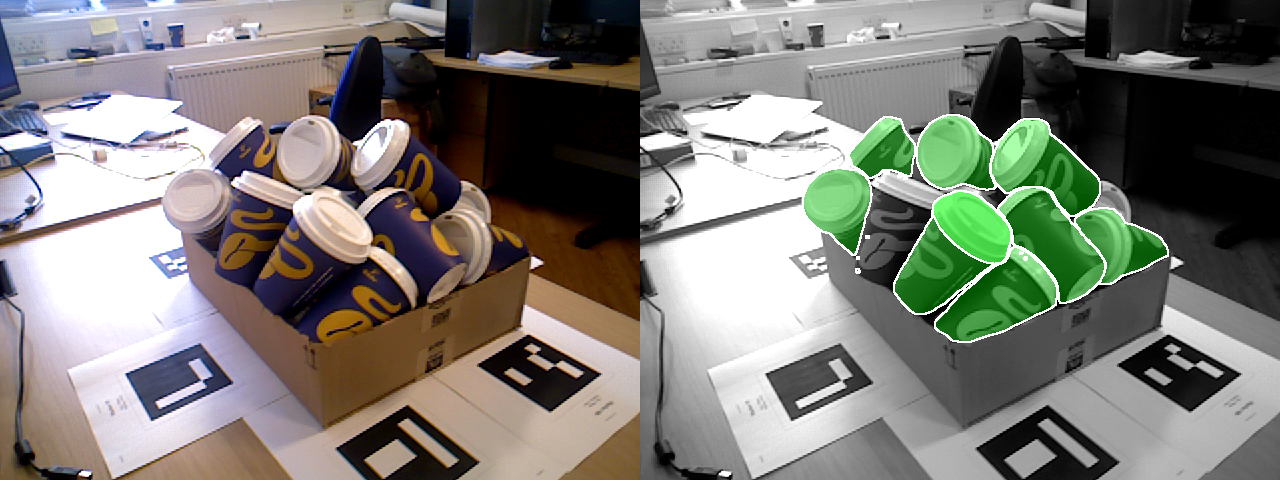

In [ ]:
# Real Templates
file_path = f"output_cnos_analysis_5/{real_data_type}"
# custom_detections(sam_detections, proposals_features, real_ref_features, file_path = file_path, scene_id=1, frame_id=1)
custom_detections_2(sam_detections, idx_selected_proposals, file_path, scene_id=1, frame_id=1)

In [ ]:
results = np.load(npz_path)
dets = []
for res in results:
    det = {
    "scene_id": scene_id,
    "image_id": frame_id,
    "category_id": self.object_ids + 1
    if dataset_name != "lmo"
    else lmo_object_ids[self.object_ids],
    "score": self.scores,
    "bbox": boxes,
    "time": runtime,
    "segmentation": self.masks,
}

In [ ]:
input_file = f"{file_path}.json"
final_result = custom_visualize(input_file, dataset_name, rgb_path)
final_result

File output_cnos_analysis_5/train_pbr.json has been deleted.
File output_cnos_analysis_5/train_pbr.npz has been deleted.


Loading results ...: 100%|██████████| 1/1 [00:00<00:00, 34379.54it/s]


Saved predictions to output_cnos_analysis_5/train_pbr.json


100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


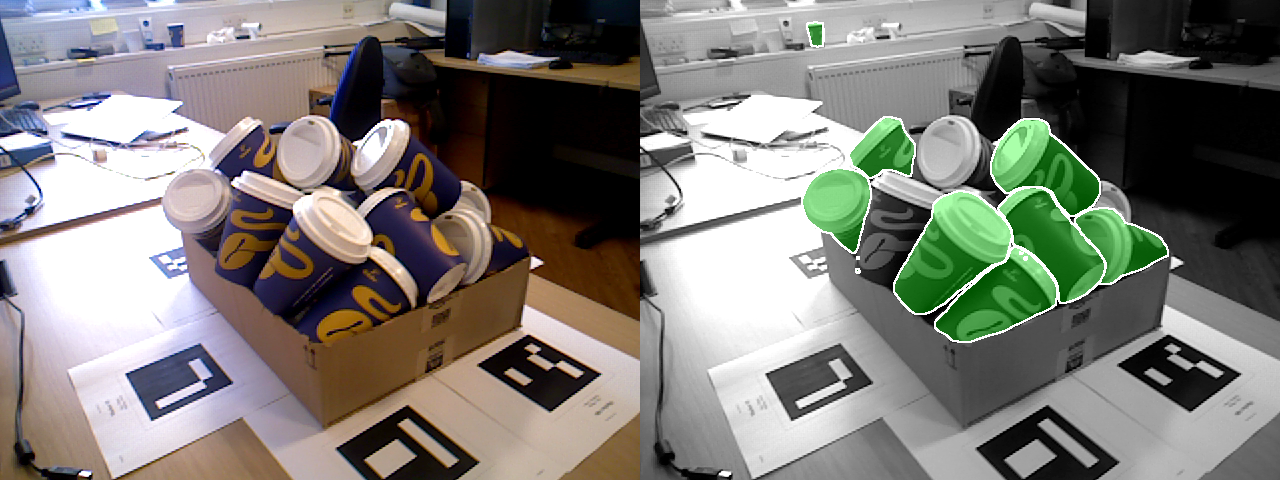

In [ ]:
# Synthetic Templates
file_path = f"output_cnos_analysis_5/{syn_data_type}"
custom_detections(sam_detections, proposals_features, syn_ref_features, file_path = file_path, scene_id=1, frame_id=1)
input_file = f"{file_path}.json"
final_result = custom_visualize(input_file, dataset_name, rgb_path)
final_result

File output_cnos_analysis_5/pyrender.json has been deleted.
File output_cnos_analysis_5/pyrender.npz has been deleted.


Loading results ...: 100%|██████████| 1/1 [00:00<00:00, 35246.25it/s]


Saved predictions to output_cnos_analysis_5/pyrender.json


100%|██████████| 7/7 [00:01<00:00,  6.34it/s]


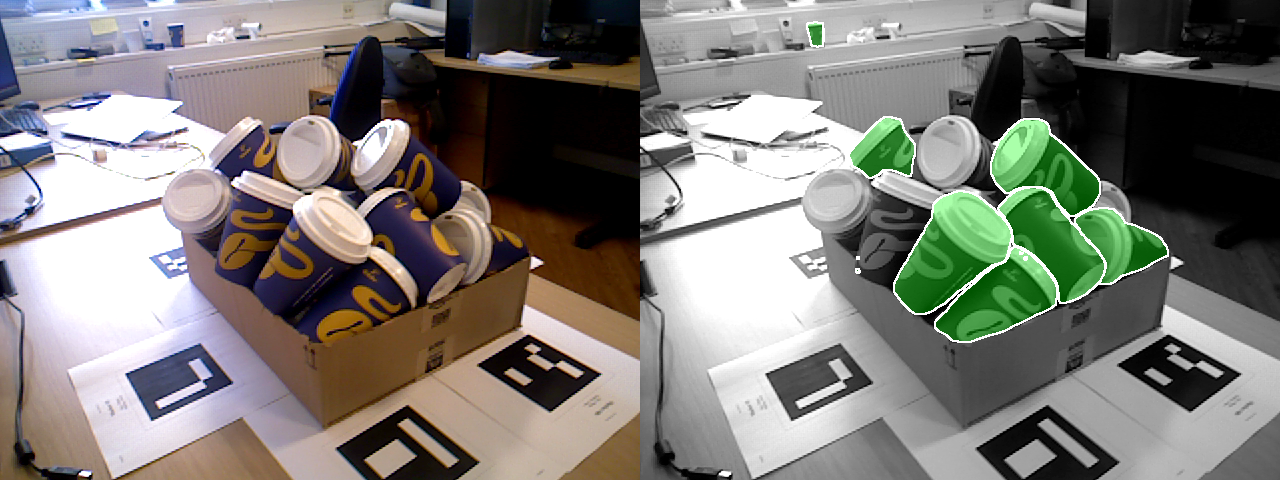

In [ ]:
# Pyrender Templates
file_path = f"output_cnos_analysis_5/pyrender"
custom_detections(sam_detections, proposals_features, pyrender_ref_features, file_path = file_path, scene_id=1, frame_id=1)
input_file = f"{file_path}.json"
final_result = custom_visualize(input_file, dataset_name, rgb_path)
final_result

In [ ]:
# from src.model.custom_cnos import modified_run_inference

# rgb_path = "cnos_analysis/crop_proposals/000001.png"
# template_dir = "foundpose_analysis/icbin/templates/test_images_templates/obj_000001_original"
# modified_run_inference(template_dir, rgb_path, sam_detections, real_ref_features, proposals_features)# , num_max_dets=15)

In [ ]:
# syn_template_dir = "foundpose_analysis/icbin/templates/train_pbr_images_templates/obj_000001_original"
# modified_run_inference(syn_template_dir, rgb_path, sam_detections, syn_ref_features, proposals_features)

In [ ]:
# pyrender_template_dir = "datasets/bop23_challenge/datasets/templates_pyrender/icbin/obj_000001"
# modified_run_inference(pyrender_template_dir, rgb_path, sam_detections, pyrender_ref_features, proposals_features)

# 5. Experiments with FoundPose

## 5.1 Apply PCA for Top 3
Change the features extract to the modified code- then run the code below

In [ ]:
# from sklearn.decomposition import PCA
# concat_features = torch.cat(( normal_features.unsqueeze(0), real_ref_features[0]), dim=0) # [325, 900, 1024]
# # PCA
# pca = PCA(n_components=3, random_state=5)
# pca_patches_descriptors = [pca.fit_transform(np.array(concat_feature)).flatten() for concat_feature in concat_features]
# pca_normal_features = torch.tensor(pca_patches_descriptors[0])
# pca_real_ref_features = torch.tensor(pca_patches_descriptors[1:])
# calculate_similarity(crop_rgb, pca_normal_features.unsqueeze(0), pca_real_ref_features, real_templates)

In [ ]:
import pickle


with open('contrastive_learning/all_pos_proposals.pkl', 'rb') as file:
    pos = pickle.load(file)

with open('contrastive_learning/all_neg_proposals.pkl', 'rb') as file:
    neg = pickle.load(file)

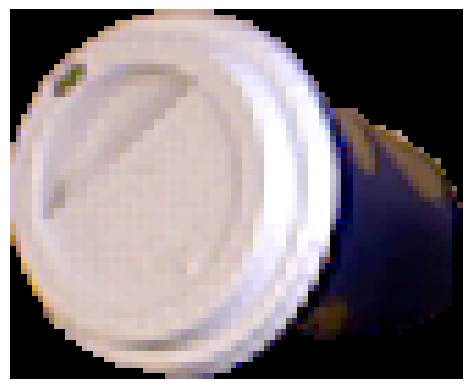

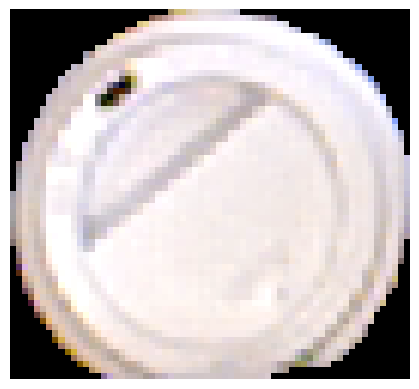

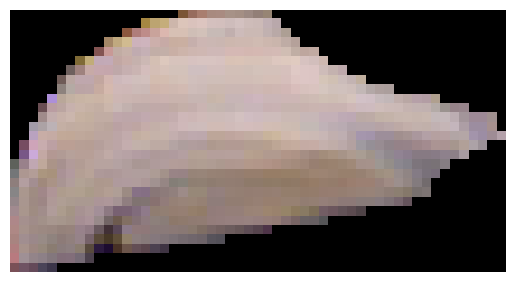

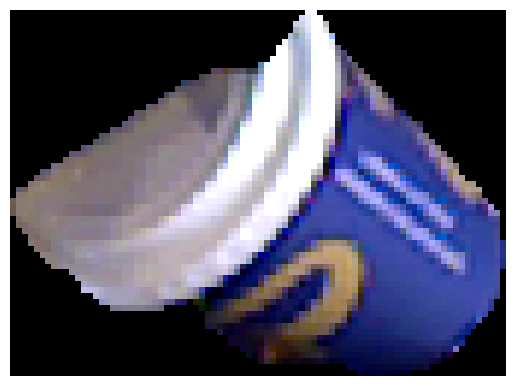

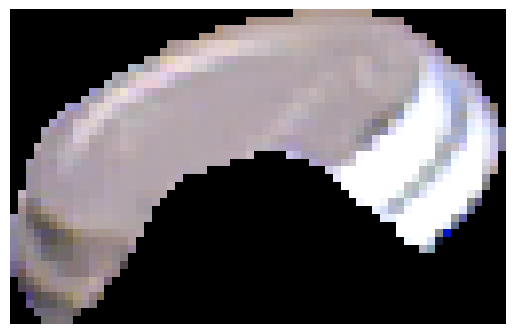

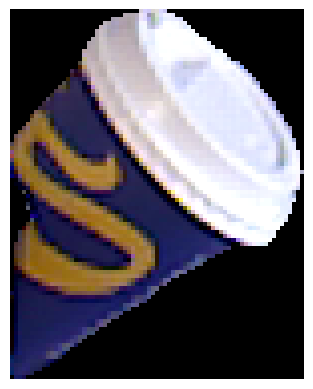

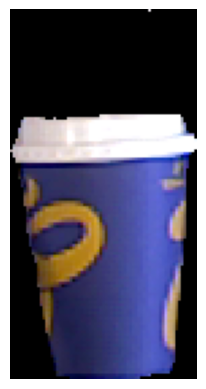

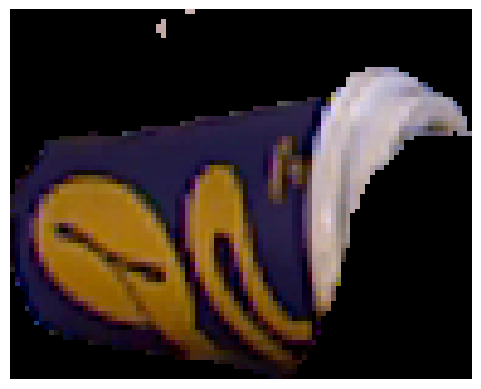

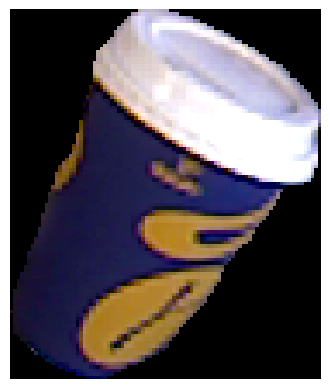

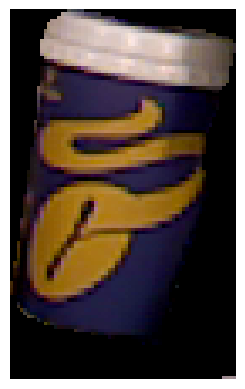

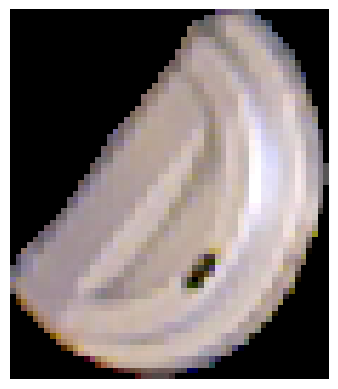

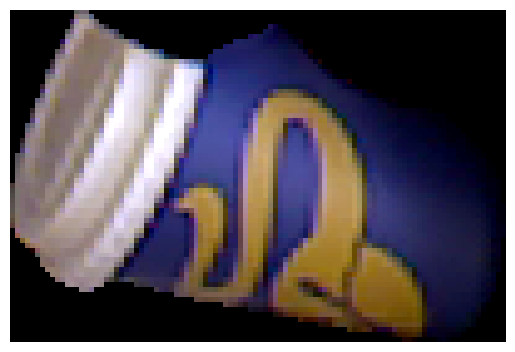

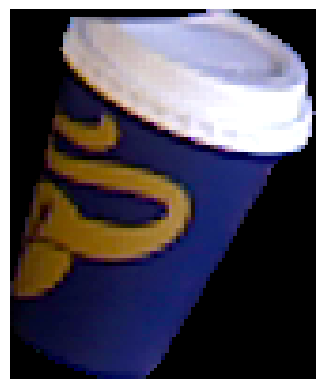

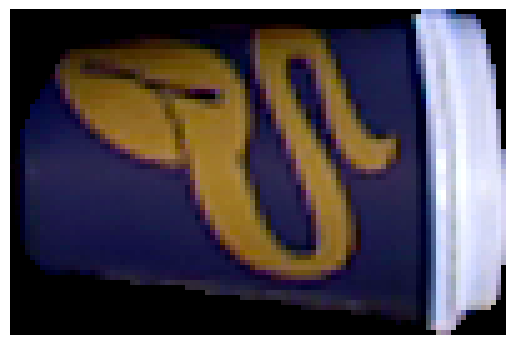

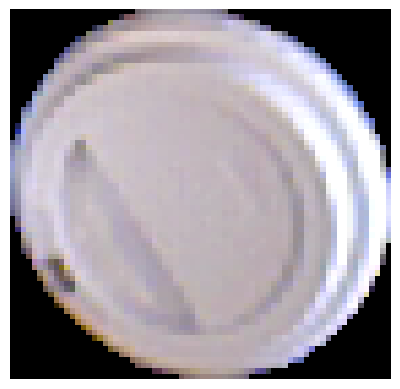

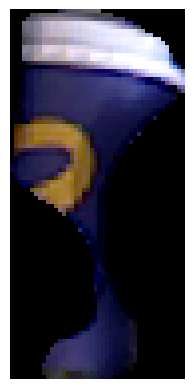

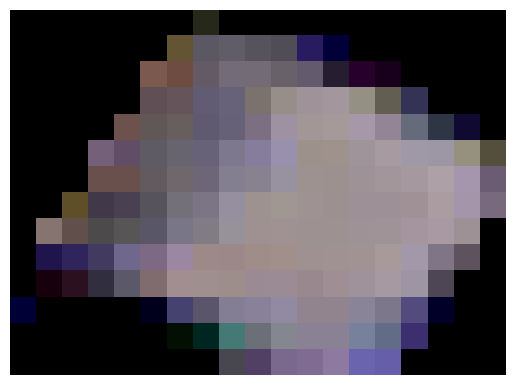

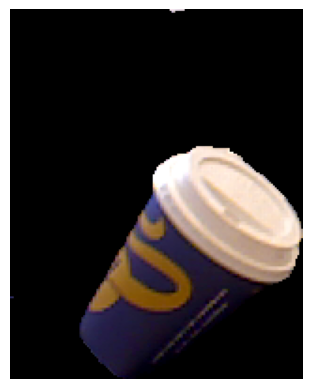

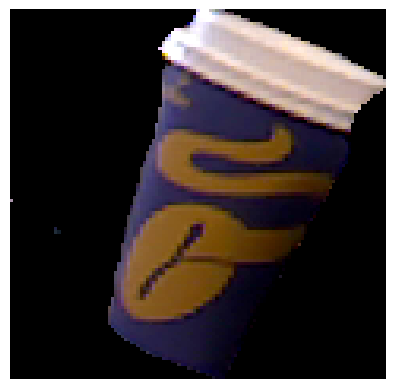

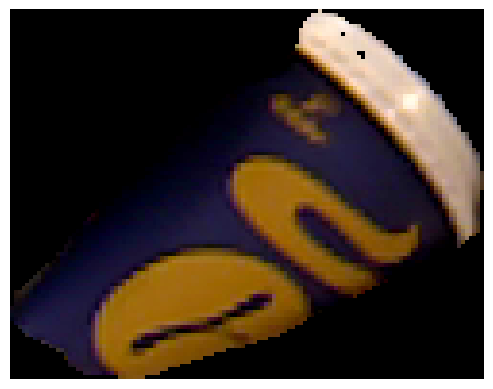

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'pos' is a list of dictionaries containing image data under the key 'rgb'
for p in pos[:20]:
    plt.figure()  # Create a new figure for each image to avoid overlapping
    plt.imshow(p["rgb"])  # Display the image
    plt.axis('off')  # Hide the axis for a cleaner look
    plt.show()  # Show the image


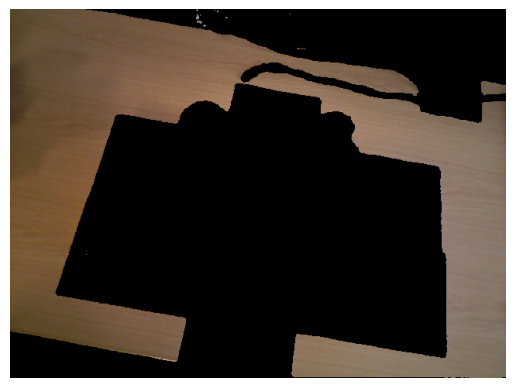

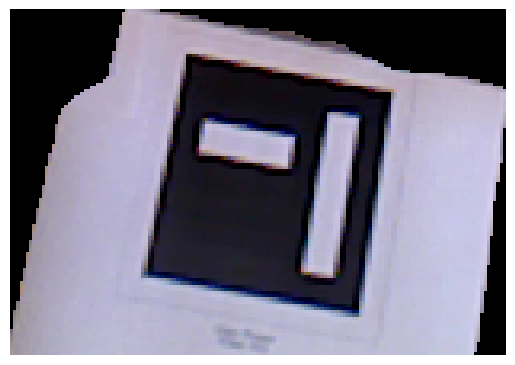

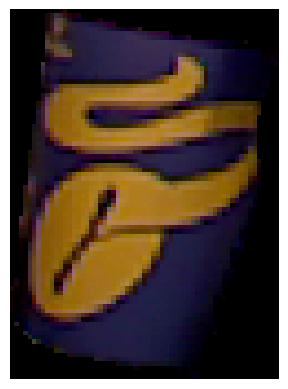

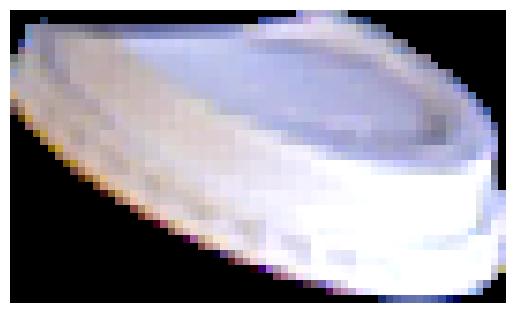

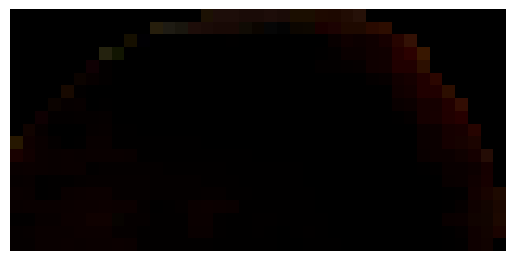

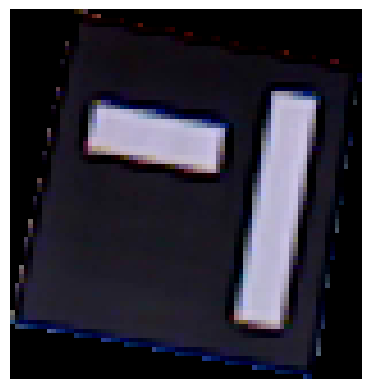

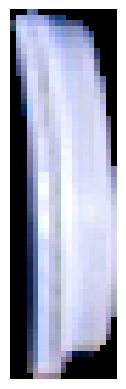

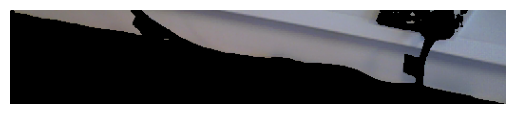

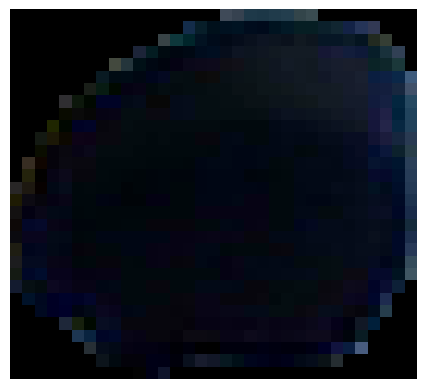

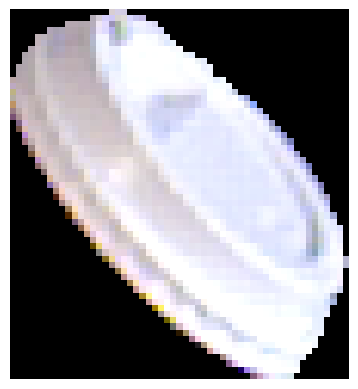

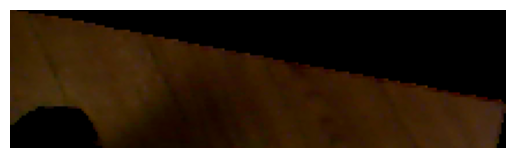

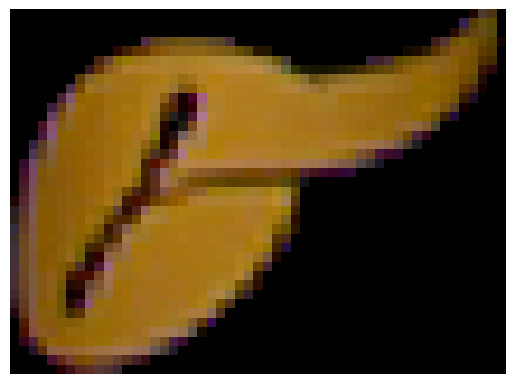

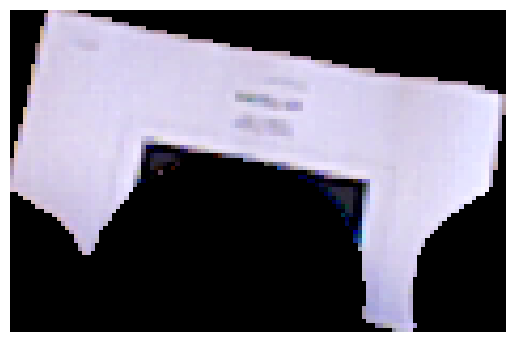

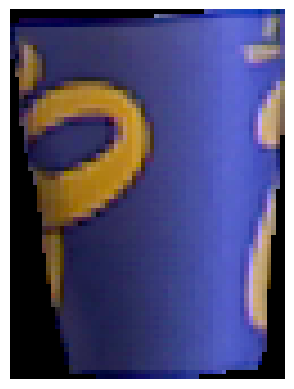

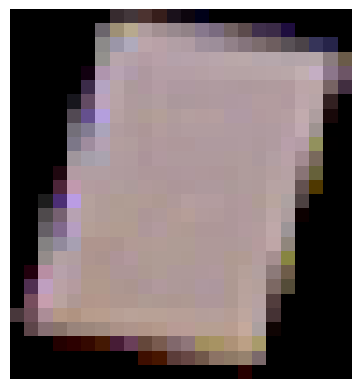

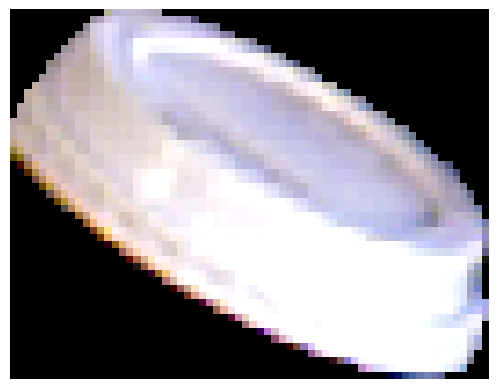

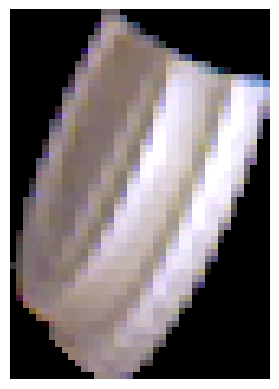

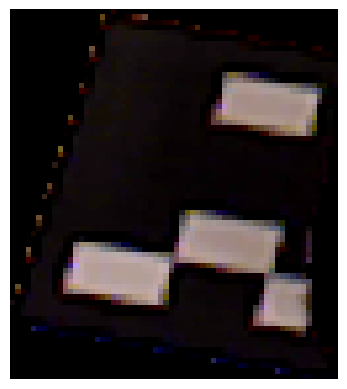

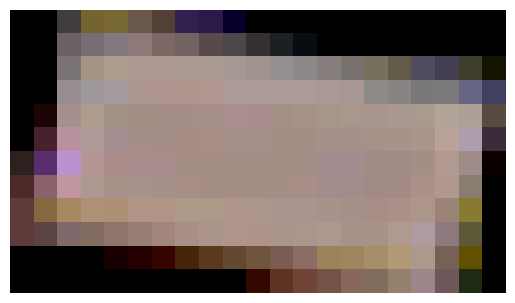

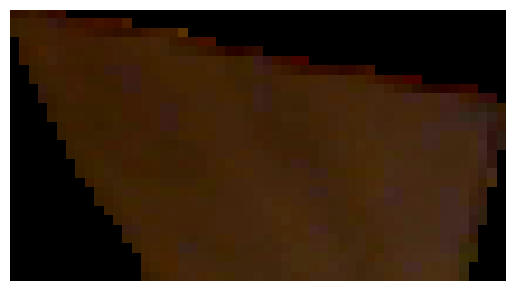

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'pos' is a list of dictionaries containing image data under the key 'rgb'
for n in neg[:20]:
    plt.figure()  # Create a new figure for each image to avoid overlapping
    plt.imshow(n)  # Display the image
    plt.axis('off')  # Hide the axis for a cleaner look
    plt.show()  # Show the image


In [ ]:
len(pos)

714